In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import modularity

def try_split(g, nodes):                  #splits a given community
    # Create the subgraph for the community
    sg = g.subgraph(nodes)
    if sg.number_of_nodes() <= 1:
        return None
    # Get adj matrix and degrees
    a_c = nx.to_numpy_array(sg, nodelist=nodes)
    k = np.sum(a_c, axis=1)
    m = k.sum() / 2
    # Avoid division by zero for isolated nodes
    if m == 0:
        return None
    # Modularity matrix
    b_c = a_c - np.outer(k, k) / (2 * m)
    # Get the eigenvectors
    try:
        vals, vecs = np.linalg.eigh(b_c)
        u1 = vecs[:, -1]  # Vector for largest eigenvalue
        l1 = vals[-1]     # Largest eigenvalue
    except np.linalg.LinAlgError:
        return None
    # Check if the split can be done
    if l1 < 1e-10: # Use a small tolerance
        return None
    #Split nodes based on the eigenvector's sign
    c1 = []
    c2 = []
    for i, node in enumerate(nodes):
        if u1[i] > 0:
            c1.append(node)
        else:
            c2.append(node)

    # Handle edge case: all nodes went to one side
    if not c1 or not c2:
        return None

    return c1, c2

In [18]:
def get_metrics(g, comms):          #calculates all community  metrics
    # Store metrics for this state
    d_cen = {}
    b_cen = {}
    c_cen = {}
    c_coe = {}

    # Build a quick map of node -> its community
    n_to_c = {}
    for c in comms:
        for n in c:
            n_to_c[n] = c
    # Calculate metrics for each node
    for n in g.nodes():
        c = n_to_c[n]
        sg = g.subgraph(c)
        n_count = sg.number_of_nodes()

        # Calculate metrics within the subgraph
        if n_count > 1:
            d_cen[n] = nx.degree_centrality(sg).get(n, 0)
            b_cen[n] = nx.betweenness_centrality(sg, normalized=True).get(n, 0)
            c_cen[n] = nx.closeness_centrality(sg).get(n, 0)
        else:
            # Handle single-node communities
            d_cen[n] = 0
            b_cen[n] = 0
            c_cen[n] = 0

        # Clustering is calculated on the subgraph
        c_coe[n] = nx.clustering(sg).get(n, 0)

    return d_cen, b_cen, c_cen, c_coe

In [19]:
def plot_state(g, pos, comms, iter):    #plots graph with colored nodes
    print(f'Iteration Number: {iter}')

    # Create a color map for nodes
    c_map = {}
    for i, c in enumerate(comms):
        for n in c:
            c_map[n] = i

    colors = [c_map[n] for n in g.nodes()]

    plt.figure() # Create a new figure
    nx.draw(g, pos, with_labels=True, node_color=colors, cmap=plt.cm.tab10)
    plt.title(f"Split Level: {iter} ({len(comms)} communities)")
    plt.show()

In [20]:
def plot_metrics(history, n_count):     #function to plot the evolution of centrality metrics of each node
    n_iters = len(history)
    x_axis = list(range(n_iters))

    # Transpose the data for easy plotting
    d_hist = {n: [] for n in range(n_count)}
    b_hist = {n: [] for n in range(n_count)}
    c_hist = {n: [] for n in range(n_count)}
    l_hist = {n: [] for n in range(n_count)} # local clustering

    for state in history:
        d, b, c, l = state
        for i in range(n_count):
            d_hist[i].append(d[i])
            b_hist[i].append(b[i])
            c_hist[i].append(c[i])
            l_hist[i].append(l[i])

    # Plot each node
    for i in range(n_count):
        # Create a new figure for each node's plot
        plt.figure()
        ax = plt.gca()

        plt.plot(x_axis, d_hist[i], label='degree')
        plt.plot(x_axis, b_hist[i], label='betweenness')
        plt.plot(x_axis, c_hist[i], label='closeness')
        plt.plot(x_axis, l_hist[i], label='clustering')

        # Set x-ticks to be the exact integers [0, 1, 2, ...]
        plt.xticks(x_axis)

        plt.title(f'Centrality values of node {i}')
        plt.xlabel('Split Level')
        plt.ylabel('Centrality Values')
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.tight_layout()
        plt.show()

Initial Graph Properties:
Loaded Zachary's Karate Club graph
Total Nodes: 34
Total Edges: 78
Iteration Number: 0


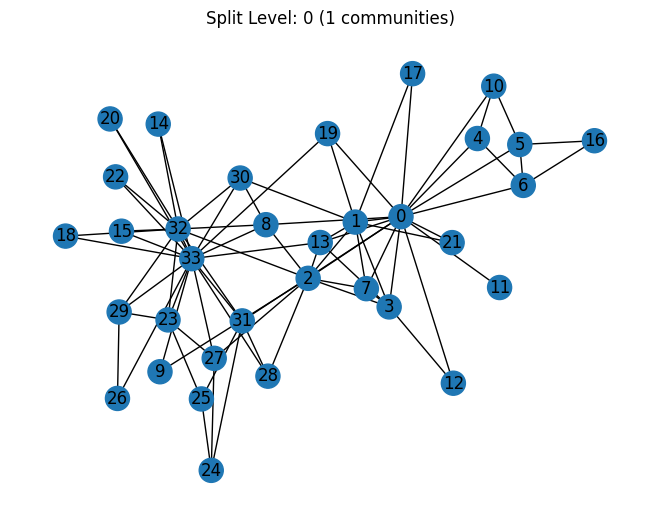

Iteration Number: 1


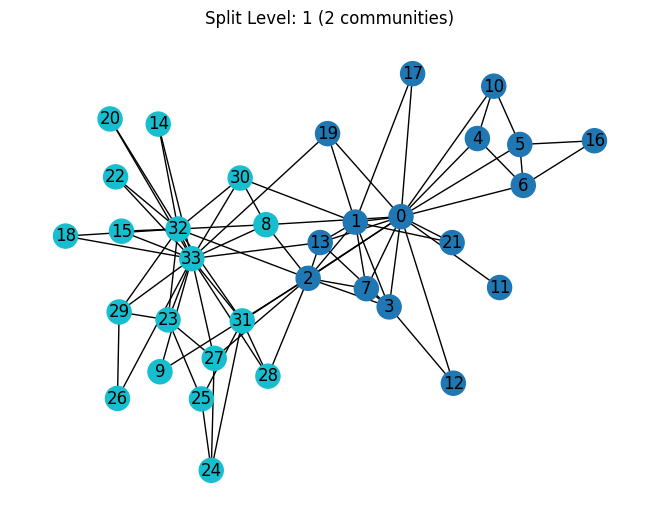

Iteration Number: 2


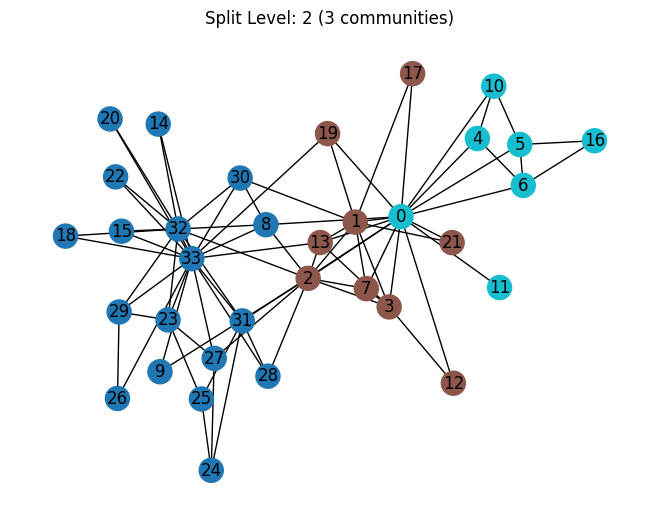

Iteration Number: 3


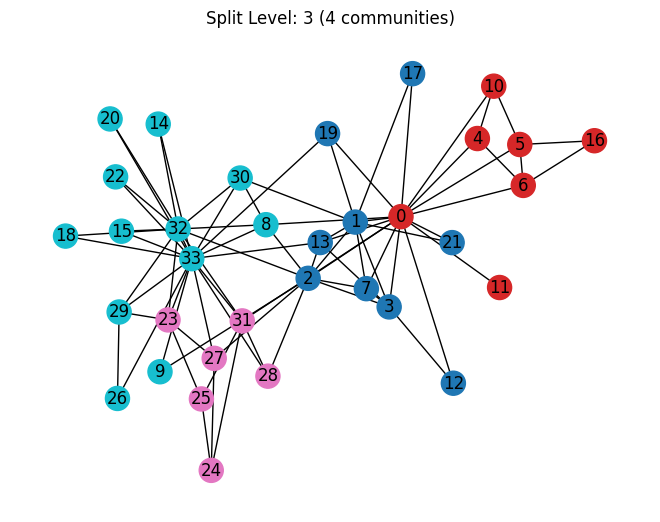


4 clusters were identified



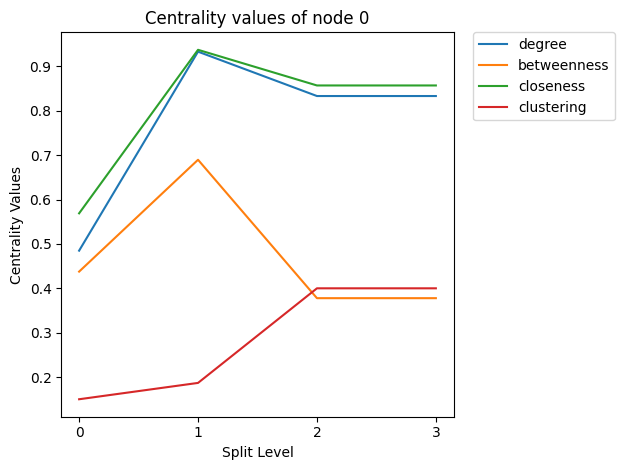

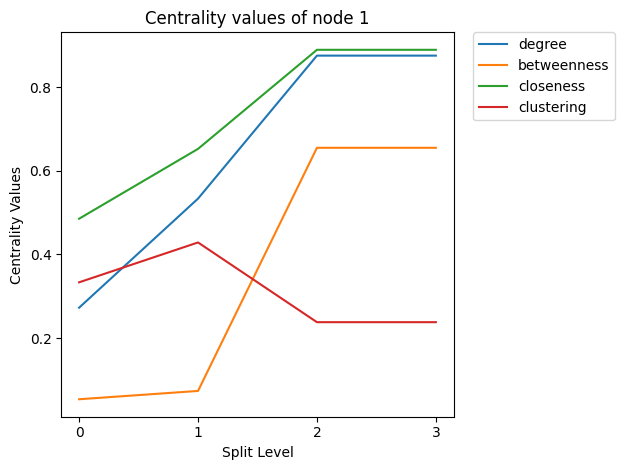

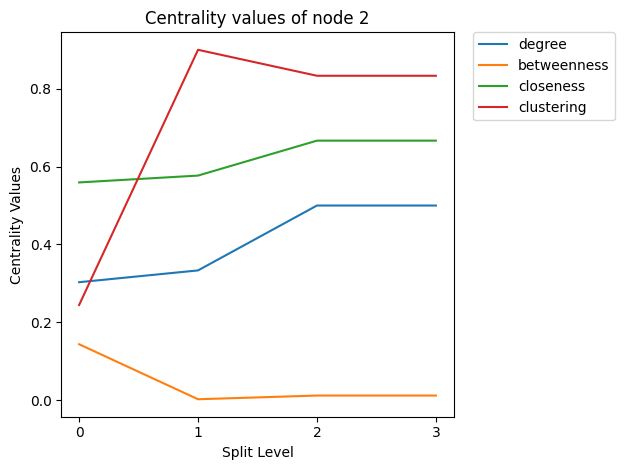

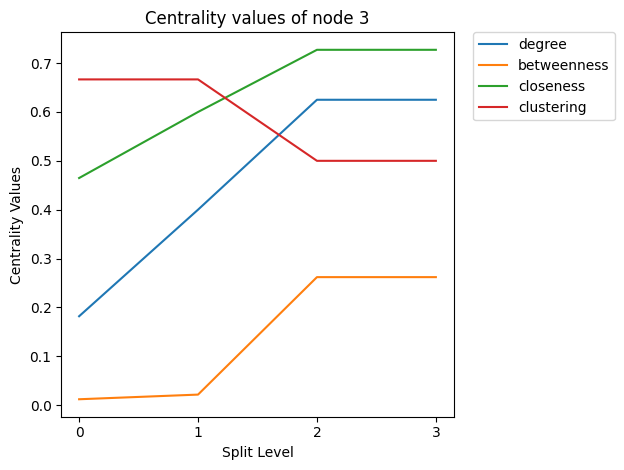

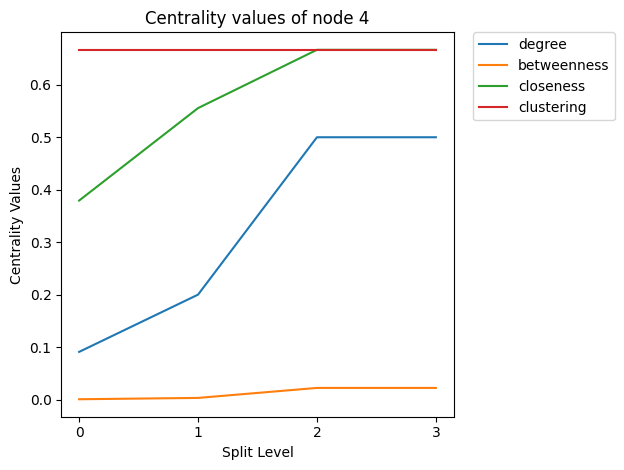

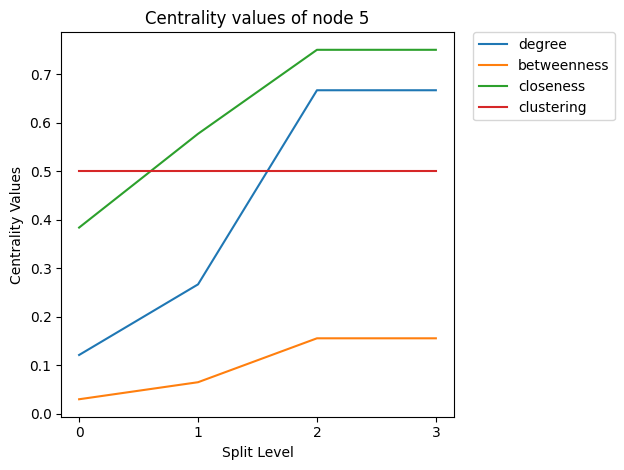

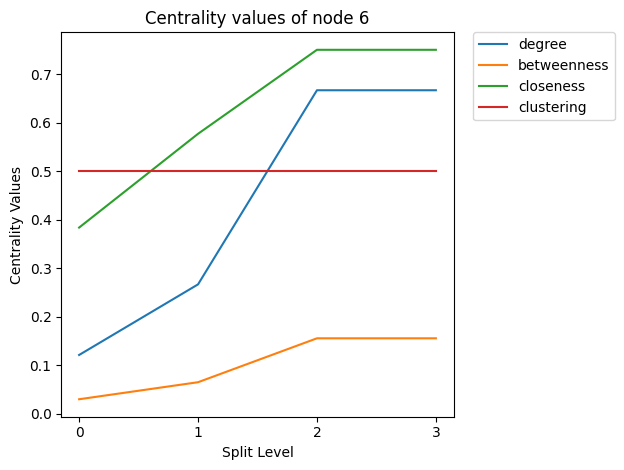

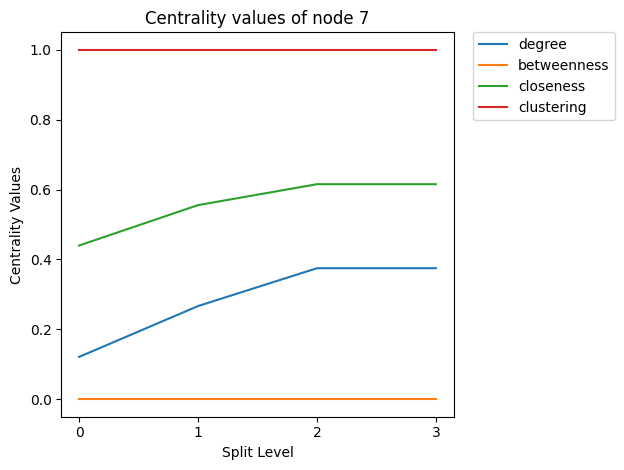

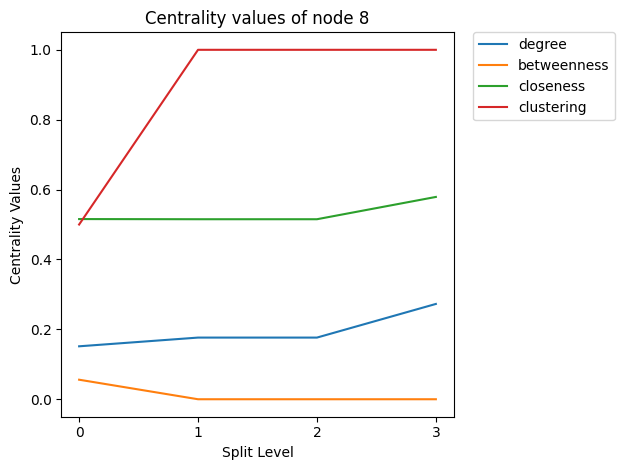

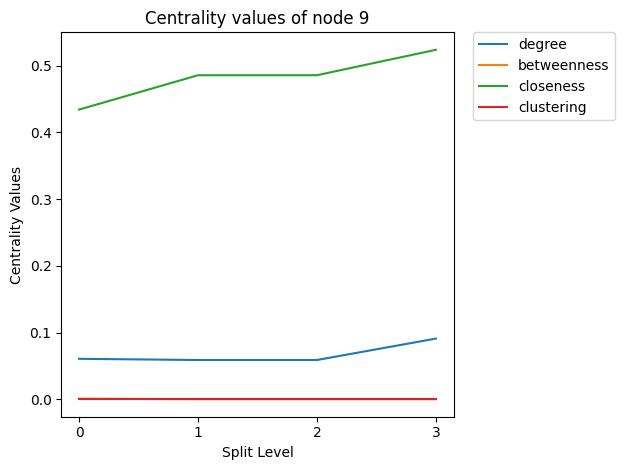

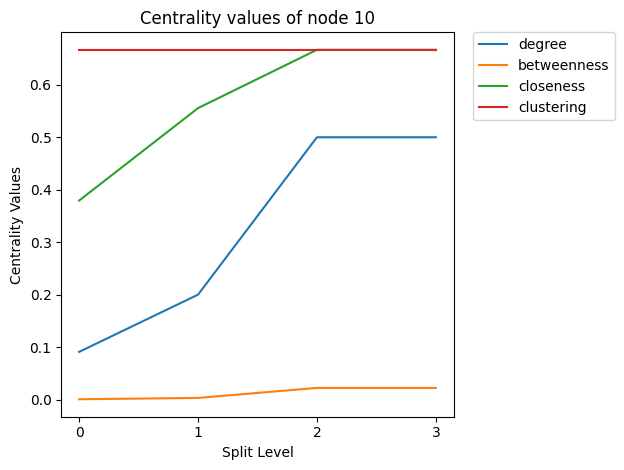

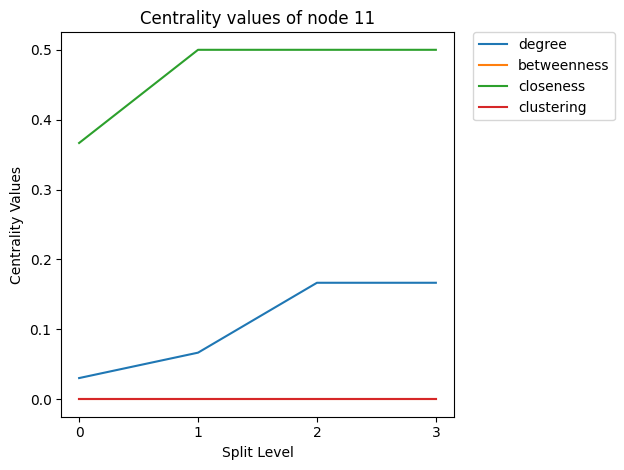

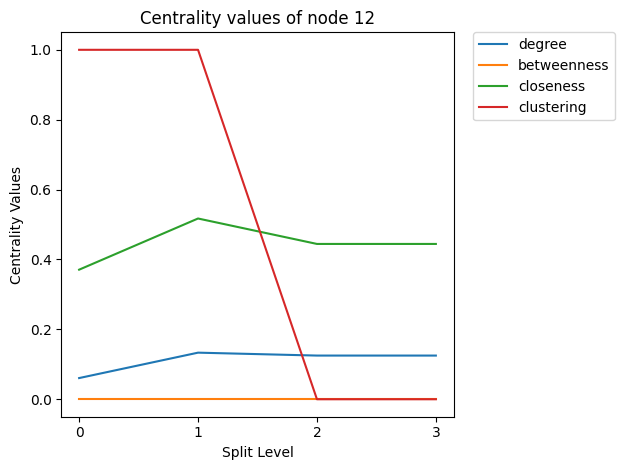

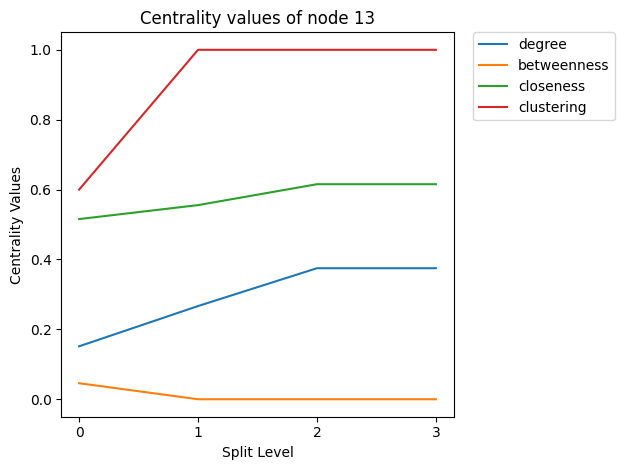

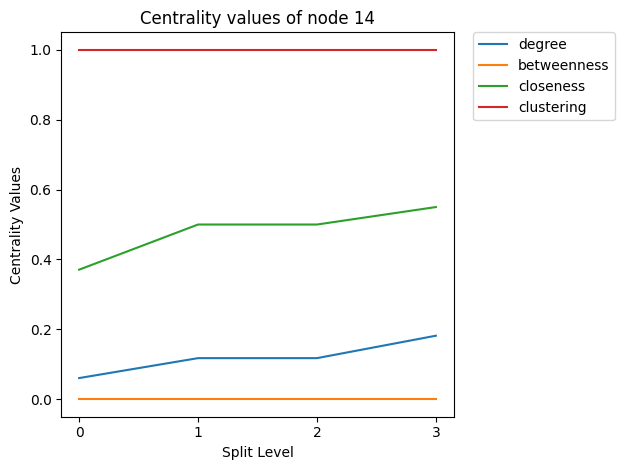

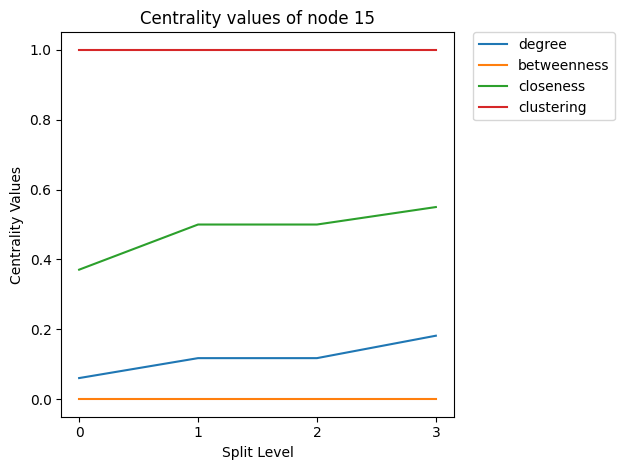

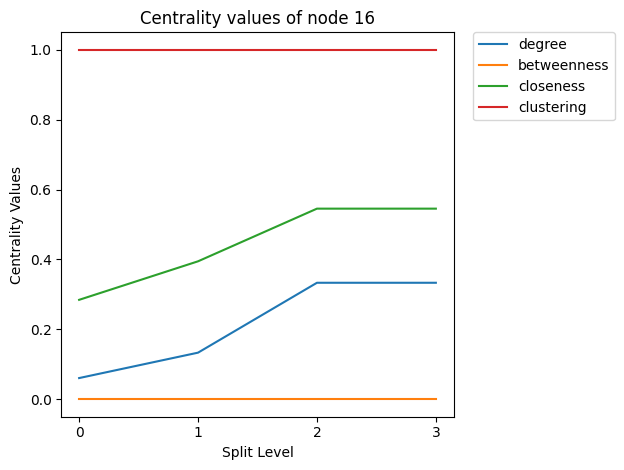

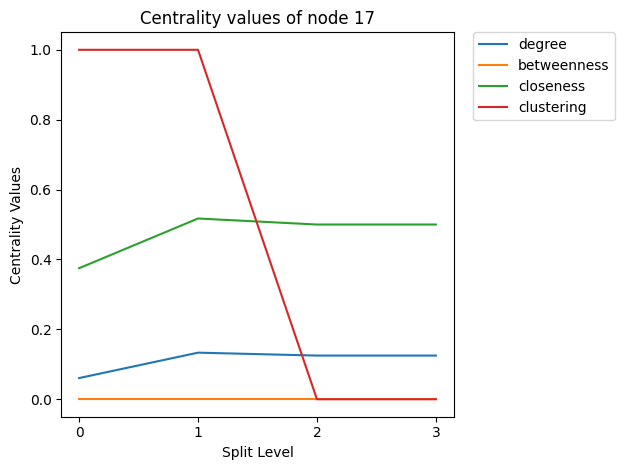

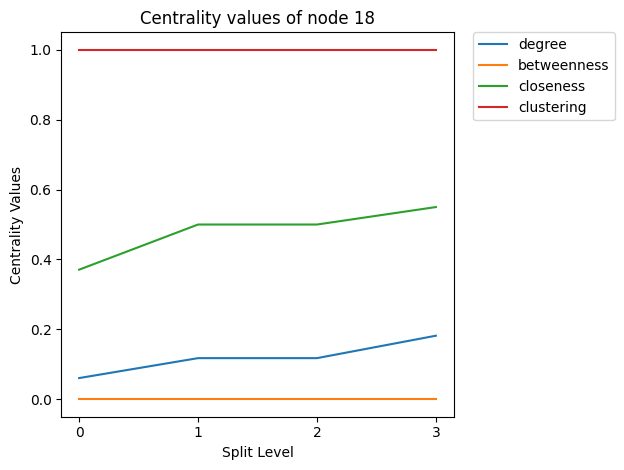

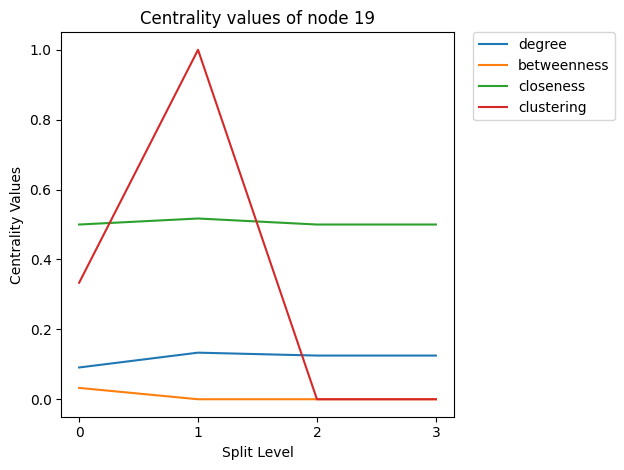

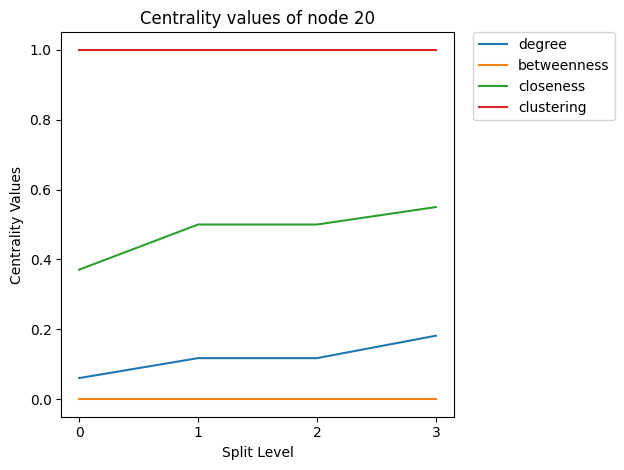

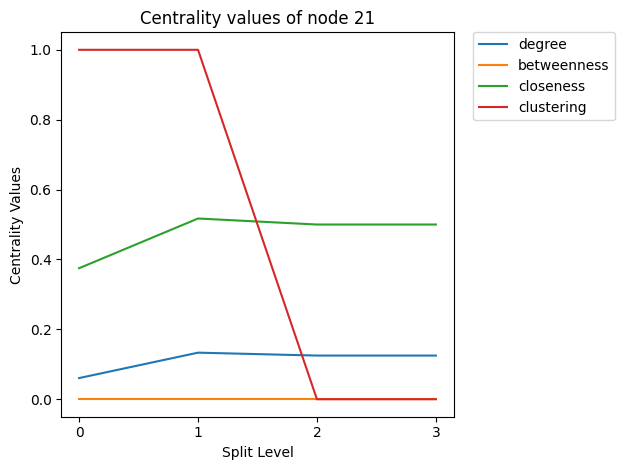

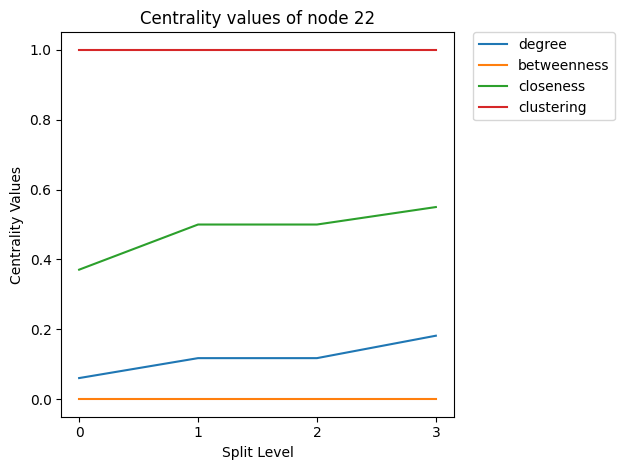

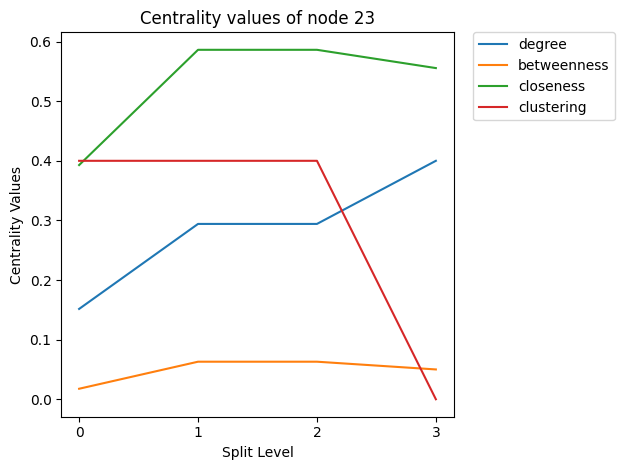

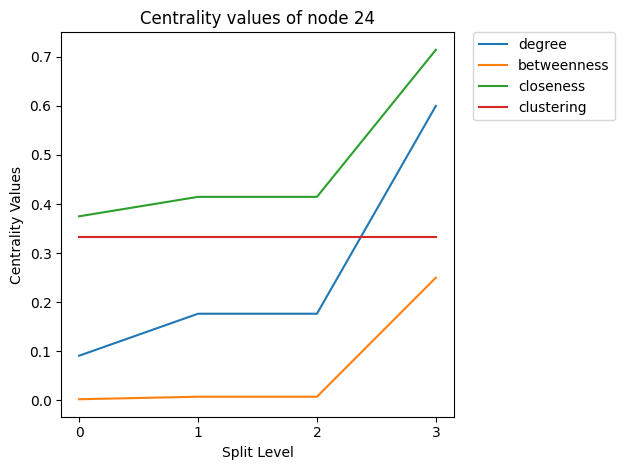

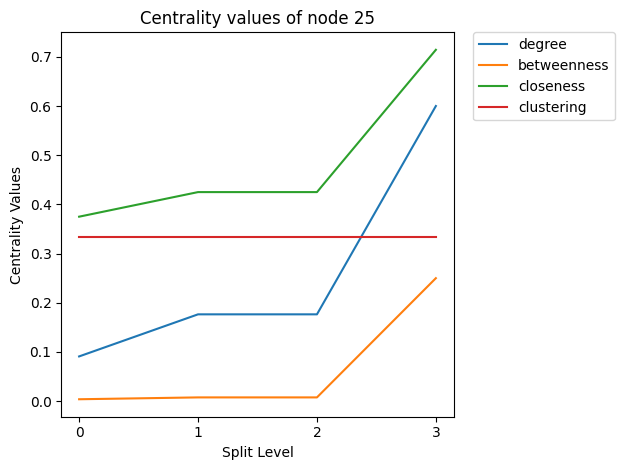

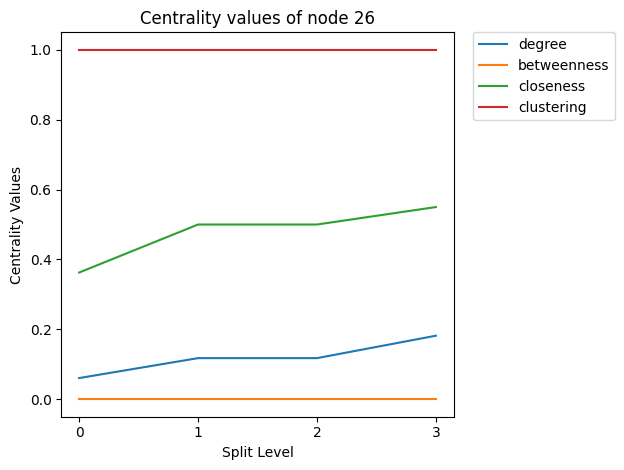

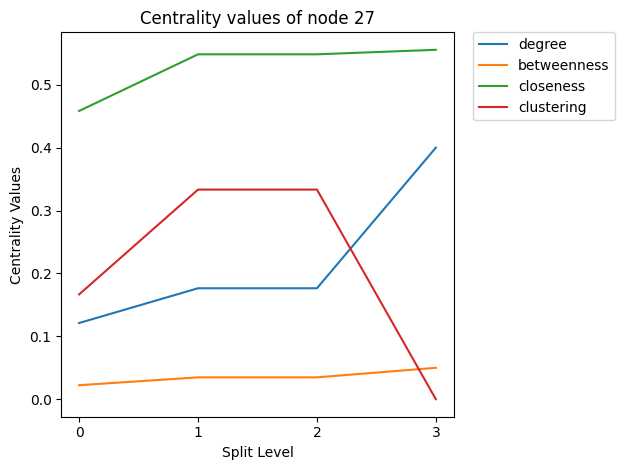

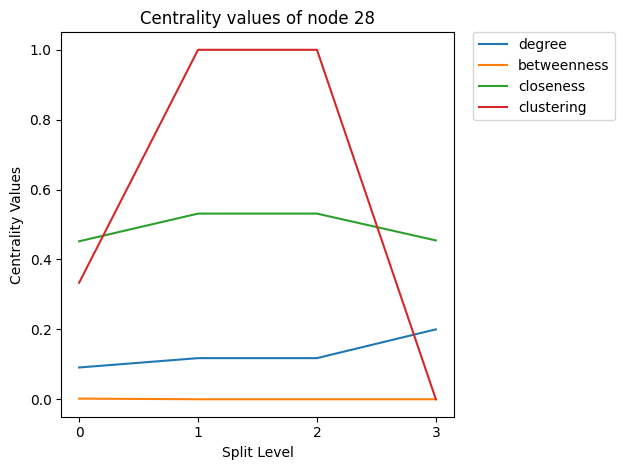

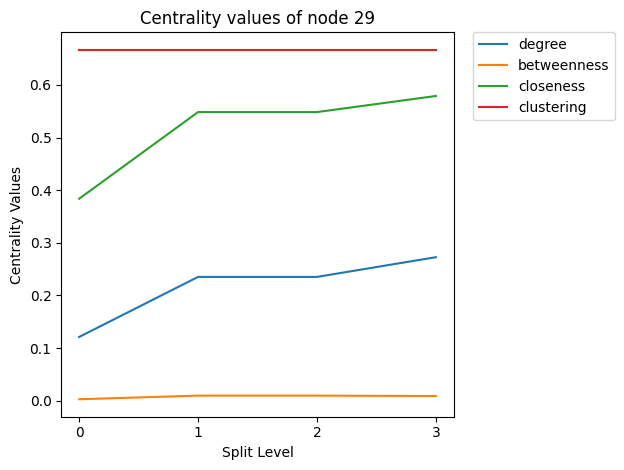

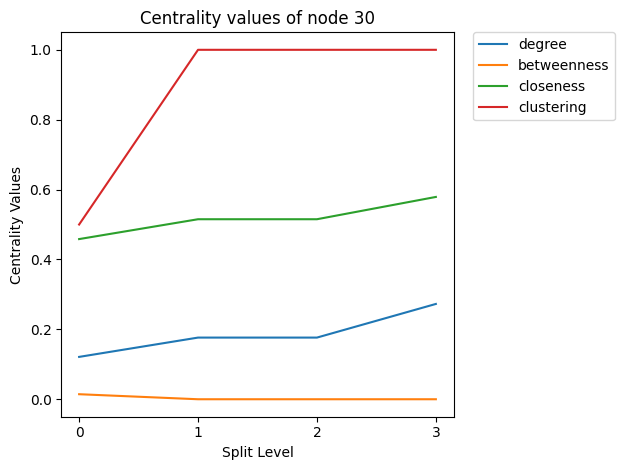

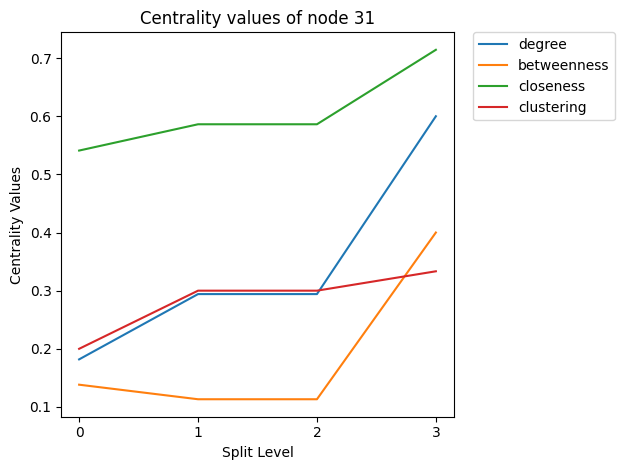

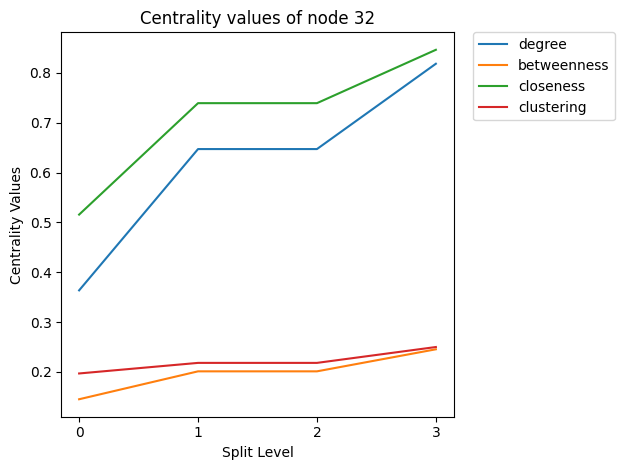

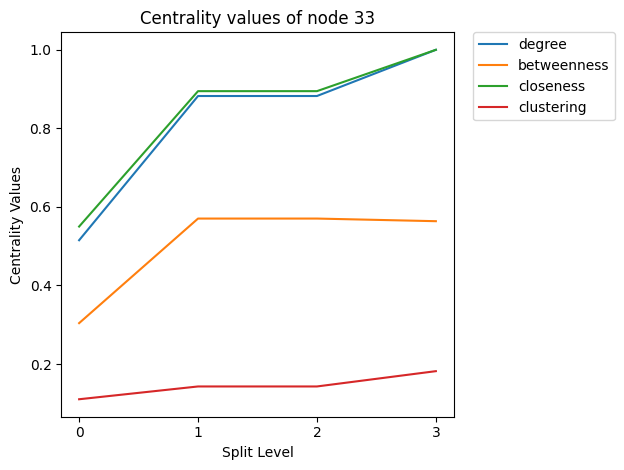

In [21]:
def main():
    g = nx.karate_club_graph()
    n_count = g.number_of_nodes()
    pos = nx.spring_layout(g, seed=4)
    print("Initial Graph Properties:")
    print(f"Loaded Zachary's Karate Club graph")
    print(f"Total Nodes: {n_count}")
    print(f"Total Edges: {g.number_of_edges()}")
    # Store history of metrics
    history = []
    iter = 0
    comms = [set(g.nodes())]
    history.append(get_metrics(g, comms))
    plot_state(g, pos, comms, iter)
    # 'queue' holds communities that are going to be split
    queue = [list(g.nodes())]
    # 'final' holds communities that cannot be further split
    final = []
    mod = modularity(g, [set(c) for c in queue])

    while queue:
        # Get a community to process
        c_nodes = queue.pop(0)
        # Try to split it based on its structure
        res = try_split(g, c_nodes)

        if res is None:
            final.append(c_nodes)
            continue

        c1, c2 = res

       # Check if this split improves modularity score

        # Create the potential new list of all communities
        temp_list = [set(c) for c in final + queue]
        temp_list.append(set(c1))
        temp_list.append(set(c2))

        new_mod = modularity(g, temp_list)

        if new_mod > mod:
            mod = new_mod
            queue.append(c1)
            queue.append(c2)

            iter += 1
            all_comms = [set(c) for c in final + queue]

            plot_state(g, pos, all_comms, iter)
            history.append(get_metrics(g, all_comms))

        else:
            final.append(c_nodes)


    final = [set(c) for c in final]
    print(f'\n{len(final)} clusters were identified\n')

    plot_metrics(history, n_count)
if __name__ == "__main__":
    main()


Node 0 and 33 remain consistent across splits.

Betweenness centrality changes the most across splits. Nodes which will act as bridges will lose betweenness when the graph is partitioned and then those connections disappear.

Closeness centrality increases for nodes that end up in small, tightly connected communities as distances between nodes decrease.

Degree centrality is mostly stable, as it depends on immediate neighbors and does not change much across the splits.

Clustering coefficient will increase as clustering progresses, for nodes that become part of tightly connected communities, while it may decrease or remain stable for nodes that lose connections or remain peripheral.

Community structure has a strong impact on how we view the importance of the nodes. A node which looks central in the full graph will lose influence after the split, or may become more central inside its own smaller subcommunity.